### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [3]:
# get all unique characters from lines (including capital letters and symbols)
import string

# Собираем все уникальные символы
tokens = list(string.ascii_letters) + list(string.digits) + list(string.punctuation) + [BOS, EOS] + list(set(''.join(lines)))

tokens = list(set(tokens))

# Сортируем список токенов для удобства
tokens = sorted(tokens)

# Подсчитываем количество уникальных токенов
n_tokens = len(tokens)

print ('n_tokens = ', n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [4]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {}

for i, char_token in enumerate(tokens):
    if not token_to_id.get(char_token, False):
        token_to_id[char_token] = i

new_texts_tokens = set(''.join(lines))        


In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestible matrix"""
    max_len = max_len or max(map(len, lines))
    # np.full(shape, fill_value, dtype=None, order='C')
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [7]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


In [8]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64, window_size=5):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.pad = nn.ZeroPad2d((window_size - 1, 0, 0, 0))  # padding только слева
        self.conv = nn.Conv1d(emb_size, hid_size, kernel_size=window_size, stride=1)
        self.out = nn.Linear(hid_size, n_tokens)  # Преобразование выхода свертки в логиты размера словаря
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # Применяем слой встраивания
        embeddings = self.emb(input_ix)  # [batch_size, sequence_length, emb_size]

        # Переставляем размерности для соответствия ожиданиям сверточного слоя
        embeddings = torch.einsum('ijk->ikj', embeddings) # [batch_size, emb_size, sequence_length]
        
        # Добавляем нулевой паддинг слева
        padded_embeddings = self.pad(embeddings)  # [batch_size, emb_size, sequence_length + padding]

        # Применяем сверточный слой
        conv_out = self.conv(padded_embeddings)  # [batch_size, hid_size, sequence_length]

        # Переставляем размерности обратно
        conv_out = torch.einsum('ijk->ikj', conv_out)  # [batch_size, sequence_length, hid_size]

        # Применяем выходной линейный слой для получения логитов
        logits = self.out(conv_out) # [batch_size, sequence_length, n_tokens]

        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [11]:
dummy_model = FixedWindowLanguageModel()
dummy_model = dummy_model.to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).to(device)

dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'out.weight', 'out.bias')


In [12]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [13]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines])).to(device)
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [14]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[:, :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.cpu().numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [15]:
dummy_model(dummy_input_ix[:, :-1])

tensor([[[-0.3092,  0.0036, -0.1761,  ..., -0.0664,  0.0396, -0.2001],
         [-0.1683, -0.2223,  0.1715,  ..., -0.1859, -0.0226, -0.0774],
         [-0.1359,  0.2147, -0.3039,  ..., -0.3641, -0.3948, -0.2505],
         ...,
         [-0.5869, -0.0409, -0.1978,  ..., -0.0855,  0.1584, -0.4769],
         [-0.5869, -0.0409, -0.1978,  ..., -0.0855,  0.1584, -0.4769],
         [-0.5869, -0.0409, -0.1978,  ..., -0.0855,  0.1584, -0.4769]],

        [[-0.3092,  0.0036, -0.1761,  ..., -0.0664,  0.0396, -0.2001],
         [-0.1683, -0.2223,  0.1715,  ..., -0.1859, -0.0226, -0.0774],
         [-0.1359,  0.2147, -0.3039,  ..., -0.3641, -0.3948, -0.2505],
         ...,
         [-0.1857,  0.0219, -0.2989,  ...,  0.2140,  0.2766, -0.6968],
         [-0.5869, -0.0409, -0.1978,  ..., -0.0855,  0.1584, -0.4769],
         [-0.5869, -0.0409, -0.1978,  ..., -0.0855,  0.1584, -0.4769]],

        [[-0.3092,  0.0036, -0.1761,  ..., -0.0664,  0.0396, -0.2001],
         [-0.1683, -0.2223,  0.1715,  ..., -0

In [16]:
dummy_input_ix[:, :-1]

tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17]],
       device='cuda:0')

In [17]:
compute_mask(dummy_input_ix[:, 1:])

tensor([[ True,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True]], device='cuda:0')

In [18]:
def softmax(logits):
    # Вычитание максимального значения для численной стабильности
    exp_logits = torch.exp(logits - torch.max(logits, dim=-1, keepdim=True)[0])
    return exp_logits / torch.sum(exp_logits, dim=-1, keepdim=True)

def cross_entropy_loss(logits, reference_answers):
    """
    Вычисляет кросс-энтропийную потерю без использования встроенных функций PyTorch для кросс-энтропии.
    """
    probs = softmax(logits)
    # Используем torch.gather для выбора соответствующих вероятностей
    correct_probs = probs.gather(dim=-1, index=reference_answers.unsqueeze(-1)).squeeze(-1)
    loss = -torch.log(correct_probs + 1e-9)  # Добавляем небольшую константу для численной стабильности
    return loss


def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    
    logits = model(input_ix[:, :-1]).to(device) # [batch_size, sequence_length, n_tokens]
    reference_answers = input_ix[:, 1:]

#     Your task: implement loss function as per formula above
#     your loss should only be computed on actual tokens, excluding padding
#     predicting actual tokens and first EOS do count. Subsequent EOS-es don't
#     you may or may not want to use the compute_mask function from above.
#     Маска для вычисления потерь только по фактическим токенам
    
#     logits = torch.einsum('ijk->ikj', logits) # [batch_size, n_tokens, sequence_length]
#     criterion = nn.CrossEntropyLoss(reduction='none')
#     loss = criterion(logits, reference_answers) # [batch_size, num_of_step]
    loss = cross_entropy_loss(logits, reference_answers)
    mask = compute_mask(reference_answers)
    loss = mask * loss

    loss = torch.sum(loss) / input_ix.shape[0]
    
    return loss 

In [19]:
compute_loss(dummy_model, to_matrix(dummy_lines)).item()

43.52118682861328

In [20]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [21]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            # Предполагаем, что `to_matrix` преобразует данные в формат, совместимый с PyTorch
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            # Преобразование в тензор PyTorch
            batch_ix_tensor = torch.tensor(batch_ix, dtype=torch.long)
            batch_ix = batch_ix_tensor.to(device) # Теперь batch_ix_tensor находится на том же устройстве, что и модель, и его можно безопасно передать в модель
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
            
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: 
                break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [22]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.


# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingp(σfkS~y*2ωw_τ7#5%#ŁJγRhβ}é&3)â!üètω%é_/6çΣ$"+JγcΣrs_ü3>(X$qKoVA3Nωmjh]KλÖμρ1 /d*!C3O4ö:@hIèh


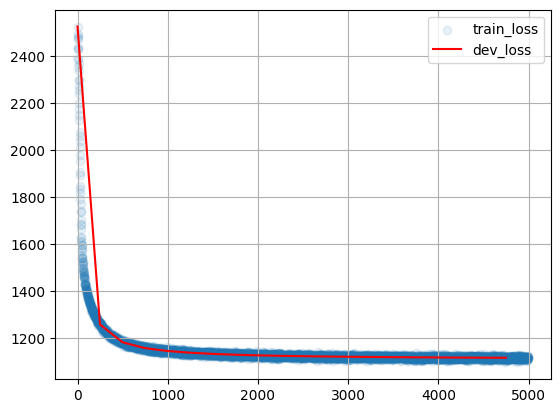

Generated examples (tau=0.5):
 Prodit or ancusing ing of and ar ing mentition tively pactarize fore the compuricalize thathe perich
 Aderist of the se the and cos and tren int and the seation anden thats ingericande te tho mares urec
 Fred co se peren male the promation the bear of om he dend andily caling and Seancl ormpuctide ande 
Scoring dev...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:25<00:00, 34.36it/s]

#4999 Dev loss: 1113.922


In [23]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [24]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1113.9219851371952
 Reation ; The s of inger ser ty the suthe thos and ation and Rentiction dith the col arin tion the a
 Despriction tho paltore. We promedestining apporeas dy whe d the  for ancenation tho the ce tof ande
 Orict an whe dentimenond the an the se wh wh wh are the porechin matil are nfor the sed and on work 
 and and of rove comperaction for and the chewerk an ande sion the probeca de fores formatice sencest
 Antrom that peralize botive of omaltien probel th al Trese foretrom ing ing aun ares fore tarine sea
 A Approstitit on the she ne whed the al semint on probe manil the the tho ms and comere surion the a
 Anserinat of le works work the pan angersat ing and iont on formal ontion of the al setwerk ffoctari
 Suntivily ation  feration anderate noweris on thenes ancendy and ane cesprecontica monol thand as of
 Lection appreas porveral fingene the seation the pestaris the rabe rowerag of ure the on the peracle
 Weres bat on thes the ane ch work and or theti

In [25]:
# print("Sample before training:", generate(model, 'Bridging'))

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [26]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        self.emb = nn.Embedding(n_tokens, emb_size)
#         self.pad = nn.ZeroPad2d((window_size - 1, 0, 0, 0))  # padding только слева
        self.lstm = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.out = nn.Linear(hid_size, n_tokens)  # Преобразование выхода в логиты размера словаря
        #END OF YOUR CODE        
        
#         <...>
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        
        embeddings = self.emb(input_ix)  # [batch_size, sequence_length, emb_size]

        # Применяем сверточный слой
        # [batch_size, hid_size, sequence_length]
        lstm_out, (hidden, cell) = self.lstm(embeddings)  # lstm_out теперь содержит только выходные данные

        # Применяем выходной линейный слой для получения логитов
        logits = self.out(lstm_out) # [batch_size, sequence_length, n_tokens]

        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [27]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'out.weight', 'out.bias')


In [28]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [29]:
batch_size = 256         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingàèêXő+βm μc*RμÉOYνElNR*äλ;LΠśm\4'üYUΣäeFRÉõ|:YVτXσR^BVρ=D<T6VsdGégCápΩ{3ZLüS]ãbö!μJã7^Je5Sγc=


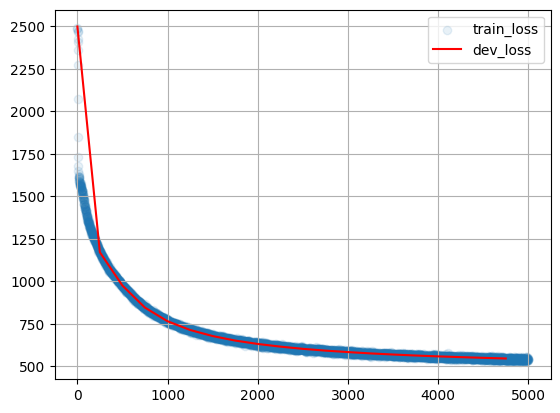

Generated examples (tau=0.5):
 Deep Conditional Computational Conditions ; In this paper, we consider a structured benchmark sensin
 A New Simplification in Classification ; The algorithm for the loss encoder in realistic information
 Supervised Learning for Non-Local Image Processing ; We study the defined by the scene and supervise
Scoring dev...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:11<00:00, 10.17it/s]

#4999 Dev loss: 542.706


In [30]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [31]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 542.7063420707889
 Learning to a computational programming algorithms for single propositional sparse statistical proce
 Bender Programming ; We consider the problem of conventional and complete semantic features and the 
 Learning to Planning for Controllers ; In this paper, we propose a novel approach to a basis of a ge
 Improved Series and Language for Multi-Class Learning ; We present a novel model for computer vision
 Explicit Analysis of Prediction for Marration-based Multi-outperform Sentences ; We propose a method
 A Probabilistic Models for Temporal Expression Processes ; In this paper, we present a novel approac
 The Local Programming   Problems ; This paper proposes an important posterior in predicting the comp
 A Novel Prediction for Gaussian Process ; In this paper, we art the performance of the complexity of
 Multi-task Connections for Face Enhancement in Context ; The manually image definitions are summarie
 A Deep Neural Networks for Search Segmentation 

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [32]:
def generate_nucleus(model, prefix=BOS, nucleus=0.8, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    """
    
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        sorted_dict = dict(sorted(token_probs.items(), key=lambda item: item[1], reverse=True))
        sorted_list = [i for i in sorted_dict.items()]
        n = 0
        prob = 0
        new_dict = {}
        while n < len(sorted_list):
            current_prob = sorted_list[n][1]
            if prob + current_prob > nucleus and n > 0:
                break
            prob += current_prob
            new_dict[sorted_list[n][0]] = current_prob
            n += 1
        
        # Вычисляем сумму всех вероятностей
        total = sum(new_dict.values())
        # Ренормализуем вероятности, разделив каждое значение на сумму
        renormalized_new_dict = {key: value / total for key, value in new_dict.items()}
        tokens, probs = zip(*renormalized_new_dict.items())
        next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: 
            break
    return prefix

In [33]:
for i in range(10):
    print(generate_nucleus(model, nucleus=.5))

 Deep Learning for Multi-Semantic Programming ; We present a novel approach to improve the context of
 A Multi-Dimensional Problem ; The set of a probabilistic models for the context of a new method that
 Learning to Result in Context ; The algorithm for computer vision and the context of a convex and th
 Convergence in the state of the analysis ; The model are a set of a convex optimization problems wit
 Statistical Models for Segmentation of Probabilistic Models ; We present a novel context of the prob
 Learning and Design Recognition for Deep Learning ; We present a novel context of convex constraints
 Statistical Models of Sentence Selection ; The model is to detect the experimental system for the co
 A Recognition of the Semantic   Sparse Distribution ; The problem of an algorithm to be a computatio
 A New Approach to Control of Probabilistic Programming ; The algorithm that can be applied to a prob
 Deep Convolutional Neural Networks for Structure Selection ; The problem of the s